=== ANALYSE UCB1 RESTLESS AVEC BRAS MIXTES ===
Configuration:
  Bras 0: Gaussien(0, 1) - moyenne = 0
  Bras 1: Bernoulli(0.2) - moyenne = 0.2
  Bras 2: Bernoulli(0.25) - moyenne = 0.25
Horizon temporel: 20000
Nombre d'expériences: 10000
Simulation de 10000 expériences sur 20000 tours...
Bras optimal: 2 avec moyenne 0.25
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']
Paramètres: [[0, 1], [0.2], [0.25]]
Vraies moyennes: [0.   0.2  0.25]
Bras optimal: 2 (moyenne: 0.25)
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']
Paramètres: [[0, 1], [0.2], [0.25]]
Vraies moyennes: [0.   0.2  0.25]
Bras optimal: 2 (moyenne: 0.25)
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']
Paramètres: [[0, 1], [0.2], [0.25]]
Vraies moyennes: [0.   0.2  0.25]
Bras optimal: 2 (moyenne: 0.25)
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']
Paramètres: [[0, 1], [0.2], [0.25]]
Vraies moyennes: [0.   0.2  0.25]
Bras optimal: 2 (moyenne: 0.25)
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']


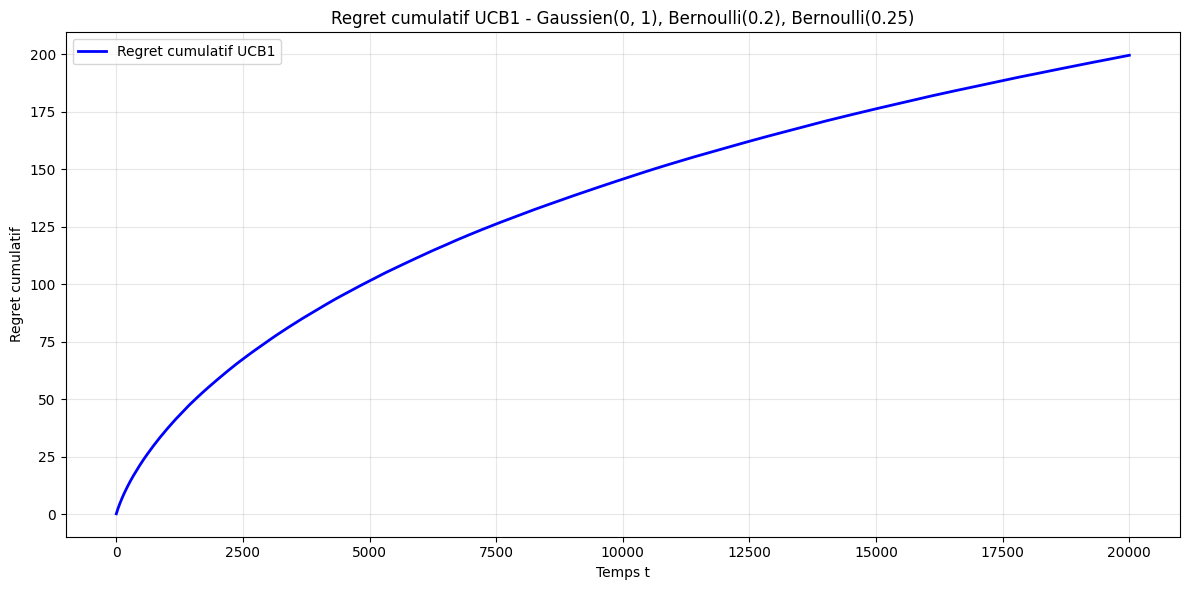

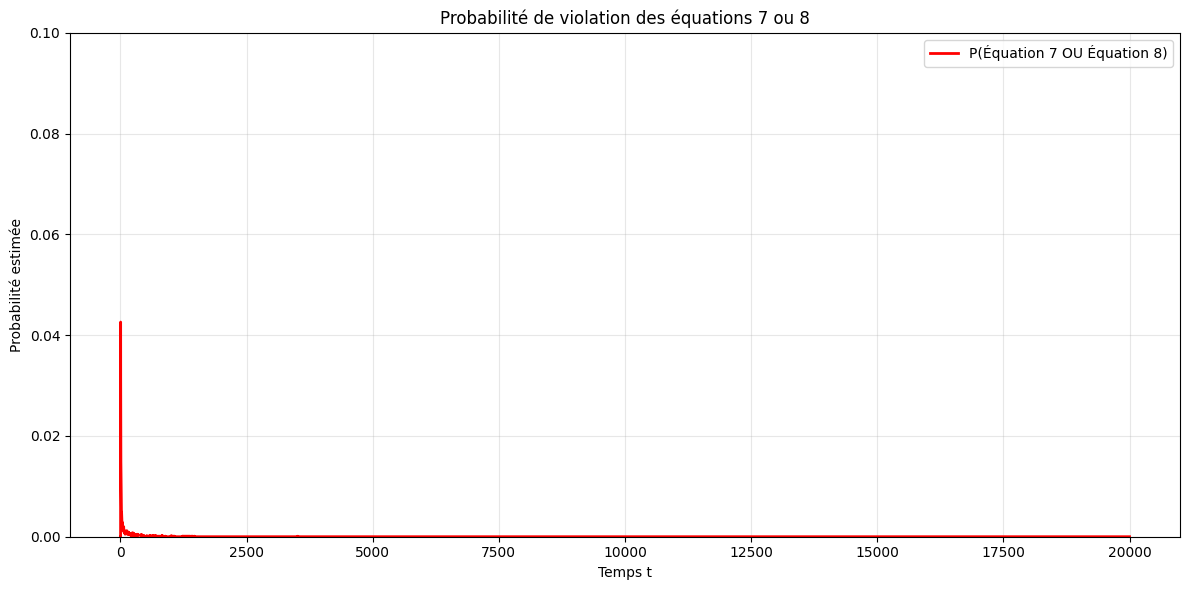


=== RÉSULTATS ===
Configuration des bras:
  Bras 0: gaussian avec paramètres [0, 1] (moyenne: 0)
  Bras 1: bernoulli avec paramètres [0.2] (moyenne: 0.2)
  Bras 2: bernoulli avec paramètres [0.25] (moyenne: 0.25)
Bras optimal: 2 (moyenne 0.25)
Regret cumulatif final: 199.63
Probabilité finale des équations 7 ou 8: 0.000000
Probabilité maximale des équations 7 ou 8: 0.042600
Probabilité moyenne: 0.000030

=== ANALYSE DÉTAILLÉE ===
Regret théorique optimal: O(log T) = O(9.90)
Regret observé: 199.63
Probabilité moyenne sur les 1000 derniers tours: 0.000000
Probabilité maximale atteinte au temps t=4: 0.042600

=== TEST DE VALIDATION ===
Types de bras: ['gaussian', 'bernoulli', 'bernoulli']
Paramètres: [[0, 1], [0.2], [0.25]]
Vraies moyennes: [0.   0.2  0.25]
Bras optimal: 2 (moyenne: 0.25)
Test rapide sur 100 tours...
Violations détectées dans le test: 0/100

Moyennes empiriques après test:
  Bras 0: empirique = -0.003, vraie = 0.000, tirages = 18
  Bras 1: empirique = 0.212, vraie = 0.20

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm
import seaborn as sns

class MixedRestlessUCB1Bandit:
    def __init__(self, arm_types, arm_params):
        """
        Initialise le bandit UCB1 en mode restless avec différents types de bras
        
        Args:
            arm_types: Liste des types de bras ('gaussian', 'bernoulli')
            arm_params: Liste des paramètres pour chaque bras
                       - Pour gaussien: [mean, std]
                       - Pour bernoulli: [p]
        """
        self.arm_types = arm_types
        self.arm_params = arm_params
        self.n_arms = len(arm_types)
        
        # Calculer les vraies moyennes pour déterminer le bras optimal
        self.true_means = []
        for i, arm_type in enumerate(arm_types):
            if arm_type == 'gaussian':
                self.true_means.append(arm_params[i][0])  # mean
            elif arm_type == 'bernoulli':
                self.true_means.append(arm_params[i][0])  # p
        
        self.true_means = np.array(self.true_means)
        self.optimal_arm = np.argmax(self.true_means)
        
        print(f"Types de bras: {arm_types}")
        print(f"Paramètres: {arm_params}")
        print(f"Vraies moyennes: {self.true_means}")
        print(f"Bras optimal: {self.optimal_arm} (moyenne: {self.true_means[self.optimal_arm]})")
        
        # Reset des statistiques
        self.reset()
    
    def reset(self):
        """Reset les statistiques du bandit"""
        self.counts = np.zeros(self.n_arms)  # Nombre de tirages par bras
        self.rewards = np.zeros(self.n_arms)  # Somme des récompenses par bras
        self.t = 0  # Temps total
        
        # Historique pour debug
        self.history = {
            'selected_arms': [],
            'rewards': [],
            'empirical_means': [],
            'confidence_bounds': [],
            'equations_satisfied': []
        }
        
    def get_empirical_means(self):
        """Calcule les moyennes empiriques"""
        means = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.counts[i] > 0:
                means[i] = self.rewards[i] / self.counts[i]
            else:
                means[i] = 0  # Pas encore joué
        return means
    
    def get_confidence_bounds(self):
        """Calcule les bornes de confiance c_{t,s}"""
        bounds = np.zeros(self.n_arms)
        if self.t > 0:  # Éviter log(0)
            for i in range(self.n_arms):
                if self.counts[i] > 0:
                    bounds[i] = np.sqrt((2 * np.log(self.t)) / self.counts[i])
                else:
                    bounds[i] = float('inf')  # Pas encore joué -> exploration
        return bounds
    
    def select_arm(self):
        """Sélectionne un bras selon UCB1"""
        # Phase d'initialisation : jouer chaque bras une fois
        if self.t < self.n_arms:
            return self.t
        
        # Phase UCB1
        empirical_means = self.get_empirical_means()
        confidence_bounds = self.get_confidence_bounds()
        
        # Calculer les valeurs UCB (Upper Confidence Bound)
        ucb_values = empirical_means + confidence_bounds
        
        # Sélectionner le bras avec la plus haute valeur UCB
        return np.argmax(ucb_values)
    
    def pull_arm(self, arm):
        """
        Tire un bras et observe la récompense
        En mode restless: tous les bras évoluent à chaque étape
        """
        # Incrémenter le temps
        self.t += 1
        
        # Générer une récompense selon le type de bras
        if self.arm_types[arm] == 'gaussian':
            mean, std = self.arm_params[arm]
            reward = norm.rvs(loc=mean, scale=std)
        elif self.arm_types[arm] == 'bernoulli':
            p = self.arm_params[arm][0]
            reward = bernoulli.rvs(p)
        else:
            raise ValueError(f"Type de bras non supporté: {self.arm_types[arm]}")
        
        # Mettre à jour les statistiques pour le bras joué
        self.counts[arm] += 1
        self.rewards[arm] += reward
        
        # Sauvegarder l'historique
        self.history['selected_arms'].append(arm)
        self.history['rewards'].append(reward)
        
        return reward
    
    def check_equations_7_8(self):
        """
        Vérifie si les équations 7 ou 8 sont satisfaites
        
        Équation 7: X̄*_s ≤ μ* - c_{t,s} (bras optimal sous-estimé)
        Équation 8: X̄_{i,s_i} ≥ μ_i + c_{t,s_i} (bras sous-optimal sur-estimé)
        
        Returns:
            bool: True si au moins une des équations est satisfaite
        """
        if self.t <= self.n_arms:  # Phase d'initialisation
            return False
            
        empirical_means = self.get_empirical_means()
        confidence_bounds = self.get_confidence_bounds()
        
        eq7_satisfied = False
        eq8_satisfied = False
        
        # Équation 7: vérifier pour le bras optimal
        optimal_arm = self.optimal_arm
        if self.counts[optimal_arm] > 0:
            true_mean_optimal = self.true_means[optimal_arm]
            empirical_mean_optimal = empirical_means[optimal_arm]
            confidence_optimal = confidence_bounds[optimal_arm]
            
            eq7_satisfied = empirical_mean_optimal <= (true_mean_optimal - confidence_optimal)
        
        # Équation 8: vérifier pour tous les bras sous-optimaux
        for i in range(self.n_arms):
            if i != optimal_arm and self.counts[i] > 0:
                true_mean_i = self.true_means[i]
                empirical_mean_i = empirical_means[i]
                confidence_i = confidence_bounds[i]
                
                if empirical_mean_i >= (true_mean_i + confidence_i):
                    eq8_satisfied = True
                    break
        
        # Sauvegarder pour debug
        self.history['empirical_means'].append(empirical_means.copy())
        self.history['confidence_bounds'].append(confidence_bounds.copy())
        self.history['equations_satisfied'].append(eq7_satisfied or eq8_satisfied)
        
        return eq7_satisfied or eq8_satisfied

def simulate_mixed_bandit_experiment(arm_types, arm_params, T, n_experiments=1000):
    """
    Simule les expériences de bandit avec bras mixtes
    
    Args:
        arm_types: Types des bras
        arm_params: Paramètres des bras
        T: Horizon temporel
        n_experiments: Nombre d'expériences
    
    Returns:
        cumulative_regret: Regret cumulatif moyen
        equation_probabilities: Probabilités des équations 7 ou 8
    """
    
    # Calculer les vraies moyennes pour le regret
    true_means = []
    for i, arm_type in enumerate(arm_types):
        if arm_type == 'gaussian':
            true_means.append(arm_params[i][0])  # mean
        elif arm_type == 'bernoulli':
            true_means.append(arm_params[i][0])  # p
    
    true_means = np.array(true_means)
    optimal_reward = np.max(true_means)
    
    cumulative_regrets = np.zeros((n_experiments, T))
    equation_violations = np.zeros((n_experiments, T))
    
    print(f"Simulation de {n_experiments} expériences sur {T} tours...")
    print(f"Bras optimal: {np.argmax(true_means)} avec moyenne {optimal_reward}")
    
    for exp in range(n_experiments):
        if (exp + 1) % 100 == 0:
            print(f"Expérience {exp + 1}/{n_experiments}")
            
        bandit = MixedRestlessUCB1Bandit(arm_types, arm_params)
        cumulative_regret = 0
        
        for t in range(T):
            # Sélectionner et tirer un bras
            arm = bandit.select_arm()
            reward = bandit.pull_arm(arm)
            
            # Calculer le regret instantané
            instantaneous_regret = optimal_reward - true_means[arm]
            cumulative_regret += instantaneous_regret
            cumulative_regrets[exp, t] = cumulative_regret
            
            # Vérifier les équations 7 et 8
            equation_violations[exp, t] = int(bandit.check_equations_7_8())
    
    # Calculer les moyennes
    mean_cumulative_regret = np.mean(cumulative_regrets, axis=0)
    equation_probabilities = np.mean(equation_violations, axis=0)
    
    # Debug info
    print(f"Nombre total de violations détectées: {np.sum(equation_violations)}")
    print(f"Probabilité moyenne des violations: {np.mean(equation_probabilities):.6f}")
    print(f"Probabilité maximale: {np.max(equation_probabilities):.6f}")
    
    return mean_cumulative_regret, equation_probabilities

def plot_mixed_results_separate(mean_regret, equation_probs, arm_types, arm_params, T):
    """Trace les résultats en graphiques séparés pour bras mixtes"""
    
    time_steps = np.arange(1, len(mean_regret) + 1)
    
    # Créer une description des bras pour le titre
    arm_descriptions = []
    for i, arm_type in enumerate(arm_types):
        if arm_type == 'gaussian':
            arm_descriptions.append(f"Gaussien({arm_params[i][0]}, {arm_params[i][1]})")
        elif arm_type == 'bernoulli':
            arm_descriptions.append(f"Bernoulli({arm_params[i][0]})")
    
    title_suffix = " - " + ", ".join(arm_descriptions)
    
    # Graphique 1: Regret cumulatif
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, mean_regret, 'b-', linewidth=2, label='Regret cumulatif UCB1')
    plt.xlabel('Temps t')
    plt.ylabel('Regret cumulatif')
    plt.title(f'Regret cumulatif UCB1{title_suffix}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Graphique 2: Probabilité des équations 7 ou 8
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, equation_probs, 'r-', linewidth=2, 
             label='P(Équation 7 OU Équation 8)')
    plt.xlabel('Temps t')
    plt.ylabel('Probabilité estimée')
    plt.title('Probabilité de violation des équations 7 ou 8')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, max(0.1, np.max(equation_probs) * 1.1))  # Adapter l'échelle
    plt.tight_layout()
    plt.show()
    
    # Calculer les vraies moyennes pour l'affichage
    true_means = []
    for i, arm_type in enumerate(arm_types):
        if arm_type == 'gaussian':
            true_means.append(arm_params[i][0])
        elif arm_type == 'bernoulli':
            true_means.append(arm_params[i][0])
    
    # Afficher quelques statistiques
    print(f"\n=== RÉSULTATS ===")
    print(f"Configuration des bras:")
    for i, (arm_type, params) in enumerate(zip(arm_types, arm_params)):
        print(f"  Bras {i}: {arm_type} avec paramètres {params} (moyenne: {true_means[i]})")
    
    print(f"Bras optimal: {np.argmax(true_means)} (moyenne {max(true_means)})")
    print(f"Regret cumulatif final: {mean_regret[-1]:.2f}")
    print(f"Probabilité finale des équations 7 ou 8: {equation_probs[-1]:.6f}")
    print(f"Probabilité maximale des équations 7 ou 8: {max(equation_probs):.6f}")
    print(f"Probabilité moyenne: {np.mean(equation_probs):.6f}")

# Configuration des bras mixtes
arm_types = ['gaussian', 'bernoulli', 'bernoulli']
arm_params = [
    [0, 1],     # Gaussien standard (mean=0, std=1)
    [0.2],      # Bernoulli(0.2)
    [0.25]      # Bernoulli(0.25)
]

T = 20000
n_experiments = 10000

print("=== ANALYSE UCB1 RESTLESS AVEC BRAS MIXTES ===")
print(f"Configuration:")
print(f"  Bras 0: Gaussien(0, 1) - moyenne = 0")
print(f"  Bras 1: Bernoulli(0.2) - moyenne = 0.2")
print(f"  Bras 2: Bernoulli(0.25) - moyenne = 0.25")
print(f"Horizon temporel: {T}")
print(f"Nombre d'expériences: {n_experiments}")

# Lancer la simulation
mean_regret, equation_probs = simulate_mixed_bandit_experiment(
    arm_types, arm_params, T, n_experiments
)

# Tracer les résultats en graphiques séparés
plot_mixed_results_separate(mean_regret, equation_probs, arm_types, arm_params, T)

# Analyse supplémentaire
print(f"\n=== ANALYSE DÉTAILLÉE ===")
print(f"Regret théorique optimal: O(log T) = O({np.log(T):.2f})")
print(f"Regret observé: {mean_regret[-1]:.2f}")

# Analyse de la convergence des probabilités
if len(equation_probs) >= 1000:
    final_1000 = equation_probs[-1000:].mean()
    print(f"Probabilité moyenne sur les 1000 derniers tours: {final_1000:.6f}")

# Moments où la probabilité est maximale
if np.max(equation_probs) > 0:
    max_prob_time = np.argmax(equation_probs) + 1
    print(f"Probabilité maximale atteinte au temps t={max_prob_time}: {max(equation_probs):.6f}")
else:
    print("Aucune violation des équations détectée")

# Test avec un exemple simple pour validation
print(f"\n=== TEST DE VALIDATION ===")
test_bandit = MixedRestlessUCB1Bandit(arm_types, arm_params)
print("Test rapide sur 100 tours...")
violations_test = 0
for i in range(100):
    arm = test_bandit.select_arm()
    test_bandit.pull_arm(arm)
    if test_bandit.check_equations_7_8():
        violations_test += 1

print(f"Violations détectées dans le test: {violations_test}/100")

# Affichage des moyennes théoriques vs empiriques après le test
if test_bandit.t > 0:
    print(f"\nMoyennes empiriques après test:")
    empirical = test_bandit.get_empirical_means()
    for i in range(len(arm_types)):
        if test_bandit.counts[i] > 0:
            if arm_types[i] == 'gaussian':
                true_mean = arm_params[i][0]
            else:
                true_mean = arm_params[i][0]
            print(f"  Bras {i}: empirique = {empirical[i]:.3f}, vraie = {true_mean:.3f}, tirages = {int(test_bandit.counts[i])}")

In [4]:
print(equation_probs[:20])

[0.     0.     0.     0.0426 0.0316 0.0242 0.0174 0.015  0.0149 0.0138
 0.0134 0.0105 0.0088 0.0074 0.0075 0.0069 0.0077 0.0065 0.0052 0.0048]
